In [1]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from lib import *

In [2]:
@njit
def calculate_epsilon(T):
    """
    args
        T: learning duration
    returns
        A list of T epsilon values
    """
    epsilon_values = []
    
    for i in range(T):
        theta = -((1/1000000) ** (1/T)) + 1
        epsilon = (1 - theta) ** i
        epsilon_values.append(epsilon)
    
    return epsilon_values

@njit
def demand(p1t,p2t):
    """
    args:
        p1t: price of agent 1
        p2t: price of agent 2
    returns:
        d: demand for given set of prices
    """
    if p1t < p2t:
        d = 1 - p1t
    elif p1t == p2t:
        d = 0.5 * (1 - p1t)
    else:
        d = 0
    return d

@njit
def profit(p1t, p2t):
    """
    args:
        p1t: price of agent 1
        p2t: price of agent 2
    returns:
        profit for agent
    """
    return p1t * demand(p1t, p2t)

In [3]:
@njit
def select_price_WoLF(epsilon, price_grid, current_state, policy):
    u = np.random.uniform(0,1)
    if epsilon > u:
        return np.random.choice(price_grid)
    else:
        cumsum = np.cumsum(policy[np.where(price_grid == current_state)[0][0], :])
        idx = np.searchsorted(cumsum, np.array([u]))[0]
        return price_grid[idx]

In [90]:
@njit
def WoLF_PHC(alpha, delta, gamma, price_grid, T):
    # Initializing values
    epsilon = calculate_epsilon(T)
    #print(epsilon)
    i = 0
    j = 1
    t = 0
    # Initializing Q-functions
    k = len(price_grid)
    q1 = np.zeros((k, k)) 
    q2 = np.zeros((k, k)) 
    # Initializing policies
    policy_1 = np.ones((k, k)) / k
    policy_2 = np.ones((k, k)) / k
    # Initializing average policies
    avg_policy1 = np.ones((k, k)) / k
    avg_policy2 = np.ones((k, k)) / k
    # Initializing N
    N1 = np.zeros(k)
    N2 = np.zeros(k)
    # Setting random price and state for t = 0
    current_price = np.random.choice(price_grid)
    current_state = np.random.choice(price_grid)
    
    t += 1
    # Setting random price and state for t = 1
    p_next = np.random.choice(price_grid)
    s_next = np.random.choice(price_grid)
    t += 1

    # Initializing profits
    profits_1 = np.empty(1000)
    profits_1[:] = np.nan
    profits_2 = np.empty(1000)
    profits_2[:] = np.nan
    profits_1_avgs = np.zeros(T)
    profits_2_avgs = np.zeros(T)
    # MÅSKE SKAL VI INDSÆTTE EN P_TABLE

    for t in range(t, T):
        if t % 2 == 0:
            current_price = p_next
            current_profit = profit(current_price, current_state)
            profit_next = profit(current_price, s_next)
            r_t = current_profit + gamma * profit_next
            p_idx = np.where(price_grid == current_price)[0][0]
            s_next_idx = np.where(price_grid == s_next)[0][0]
            current_state_idx = np.where(price_grid == current_state)[0][0]
            max_Q = max(q1[s_next_idx, :])
            q1[current_state_idx, p_idx] = q1[current_state_idx, p_idx] + alpha * (r_t + gamma**2 * max_Q - q1[current_state_idx, p_idx])
            # Update counter for visited state
            N1[current_state_idx] += 1
            # Update policy
            #print(avg_policy1[current_state_idx, :])
            avg_policy1[current_state_idx, :] = avg_policy1[current_state_idx, :] + (1 / N1[current_state_idx]) * (policy_1[current_state_idx, :] - avg_policy1[current_state_idx, :])
            avg_policy1[current_state_idx, :] /= avg_policy1[current_state_idx, :].sum() # To ensure a legal probability distribution
            
            if np.sum(q1[current_state_idx, :] * policy_1[current_state_idx, :]) > np.sum(q1[current_state_idx, :] * avg_policy1[current_state_idx, :]):
                delta_now = delta[0]
            else:
                delta_now = delta[1]
            #p_max_idx=np.argmax(q1[current_state_idx, :])
            #delta_sa = np.zeros(k)
            #sus julius kode
            delta_sa = np.zeros(k) - delta_now / (k - 1)
            p_max_idx = np.argmax(q1[current_state_idx, :])
            delta_sa[p_max_idx] = - (delta_sa.sum() - delta_sa[p_max_idx])
            
            """
            if p_idx == p_max_idx:
                # If it's the best action, increase by delta
                delta_sa[p_idx] = delta_now
            else:
                # If it's not the best action, decrease by delta divided by number of other actions
                delta_sa[p_idx] = -delta_now / (k - 1)

            """
            policy_1[current_state_idx, :] += delta_sa
            policy_1[current_state_idx, :] = np.minimum(1, np.maximum(policy_1[current_state_idx, :], 0))
            policy_1[current_state_idx, :] /= policy_1[current_state_idx, :].sum()
            p_next = select_price_WoLF(epsilon[t], price_grid, s_next, policy_1)
            # Compute profits
            profits_1 = np.concatenate((np.array([current_profit]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)
            profit_opps = profit(current_state, current_price)
            profits_2 = np.concatenate((np.array([profit_opps]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
        else:
            current_state = s_next
            current_profit = profit(current_state,current_price)
            profit_next = profit(current_state,p_next)
            r_t = current_profit + gamma * profit_next
            s_idx=np.where(price_grid == current_state)[0][0]
            p_next_idx=np.where(price_grid == p_next)[0][0]
            current_price_idx=np.where(price_grid == current_price)[0][0]
            max_Q = max(q2[p_next_idx, :])
            q2[current_price_idx, s_idx] = q2[current_price_idx, s_idx] + alpha * (r_t + gamma**2 * max_Q - q2[current_price_idx, s_idx])
            # Update counter for visited state
            N2[current_price_idx] += 1
            # Update policy
            avg_policy2[current_price_idx, :] = avg_policy2[current_price_idx, :] + (1 / N2[current_price_idx]) * (policy_2[current_price_idx, :] - avg_policy2[current_price_idx, :])
            avg_policy2[current_price_idx, :] /= avg_policy2[current_price_idx, :].sum() # To ensure a legal probability distribution
            
            if np.sum(q2[current_price_idx, :] * policy_2[current_price_idx, :]) > np.sum(q2[current_price_idx, :] * avg_policy2[current_price_idx, :]):
                #print("hej")
                delta_now = delta[0]
            else:
                delta_now = delta[1]

            #sus julius kode  
            s_max_idx=np.argmax(q2[current_price_idx, :])
            delta_sa = np.zeros(k) - delta_now / (k - 1)
            delta_sa[s_max_idx] = - (delta_sa.sum() - delta_sa[s_max_idx])
            
            """
            s_max_idx=np.argmax(q2[current_price_idx, :])
            delta_sa = np.zeros(k)
            if s_idx == s_max_idx:
                # If it's the best action, increase by delta
                delta_sa[s_idx] = delta_now
            else:
                # If it's not the best action, decrease by delta divided by number of other actions
                delta_sa[s_idx] = -delta_now / (k - 1)
            """
            policy_2[current_price_idx, :] += delta_sa
            policy_2[current_price_idx, :] = np.minimum(1, np.maximum(policy_2[current_price_idx, :], 0))
            policy_2[current_price_idx, :] /= policy_2[current_price_idx, :].sum()
            s_next = select_price_WoLF(epsilon[t], price_grid, p_next, policy_2)
            # Compute profits
            profits_2 = np.concatenate((np.array([current_profit]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
            profit_opps = profit(current_price, current_state)
            profits_1 = np.concatenate((np.array([profit_opps]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)
            #print(policy_2)
    return q1, q2, profits_1_avgs, profits_2_avgs, profits_1, profits_2

            






In [95]:
k=6
p_grid=np.round(np.arange(k + 1) / (np.zeros(k + 1) + k), 3)
_,_,prof1,prof2,_,_=WoLF_PHC(0.3, (0.2,0.6), 0.95, p_grid, 500000)    

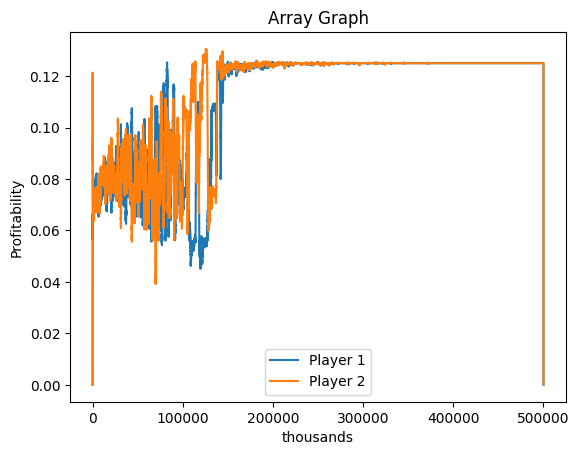

In [98]:
x_values = range(len(prof1))

# Plot the array as a line graph
plt.plot(x_values, prof1)
plt.plot(x_values, prof2)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

In [12]:
epsilon=calculate_epsilon(500000)

In [13]:
epsilon

[1.0,
 0.9999723693606172,
 0.9999447394846865,
 0.9999171103721871,
 0.9998894820230977,
 0.9998618544373973,
 0.9998342276150646,
 0.9998066015560788,
 0.9997789762604186,
 0.999751351728063,
 0.9997237279589909,
 0.9996961049531812,
 0.9996684827106128,
 0.9996408612312647,
 0.9996132405151156,
 0.9995856205621447,
 0.9995580013723305,
 0.9995303829456524,
 0.999502765282089,
 0.9994751483816194,
 0.9994475322442223,
 0.9994199168698769,
 0.9993923022585618,
 0.9993646884102562,
 0.9993370753249387,
 0.9993094630025885,
 0.9992818514431844,
 0.9992542406467053,
 0.9992266306131303,
 0.9991990213424382,
 0.9991714128346076,
 0.9991438050896181,
 0.9991161981074479,
 0.9990885918880764,
 0.9990609864314824,
 0.9990333817376449,
 0.9990057778065428,
 0.9989781746381549,
 0.99895057223246,
 0.9989229705894375,
 0.9988953697090658,
 0.9988677695913242,
 0.9988401702361915,
 0.9988125716436466,
 0.9987849738136685,
 0.9987573767462361,
 0.9987297804413282,
 0.998702184898924,
 0.998674590

In [14]:
len(np.random.uniform(size=(500000 + 2)))

500002